In [1]:
import os
import json
import albumentations as A
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.dataset import load_mask, load_bboxes, load_classIdxMap, load_stafflines
from utils.staffline_variations import default_stafflines, staffline_interruptions, thickness_variations, y_variations

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")
OUT_DIR = os.path.join(DATASET_PATH, "aug")

with open(os.path.join(DATASET_PATH, "classlist.json")) as file:
    classlist = json.load(file)
    classmap = {c["id"]:c["class"] for c in classlist}

4


'..\\..\\datasets\\generated\\png\\002\\out-0.png'

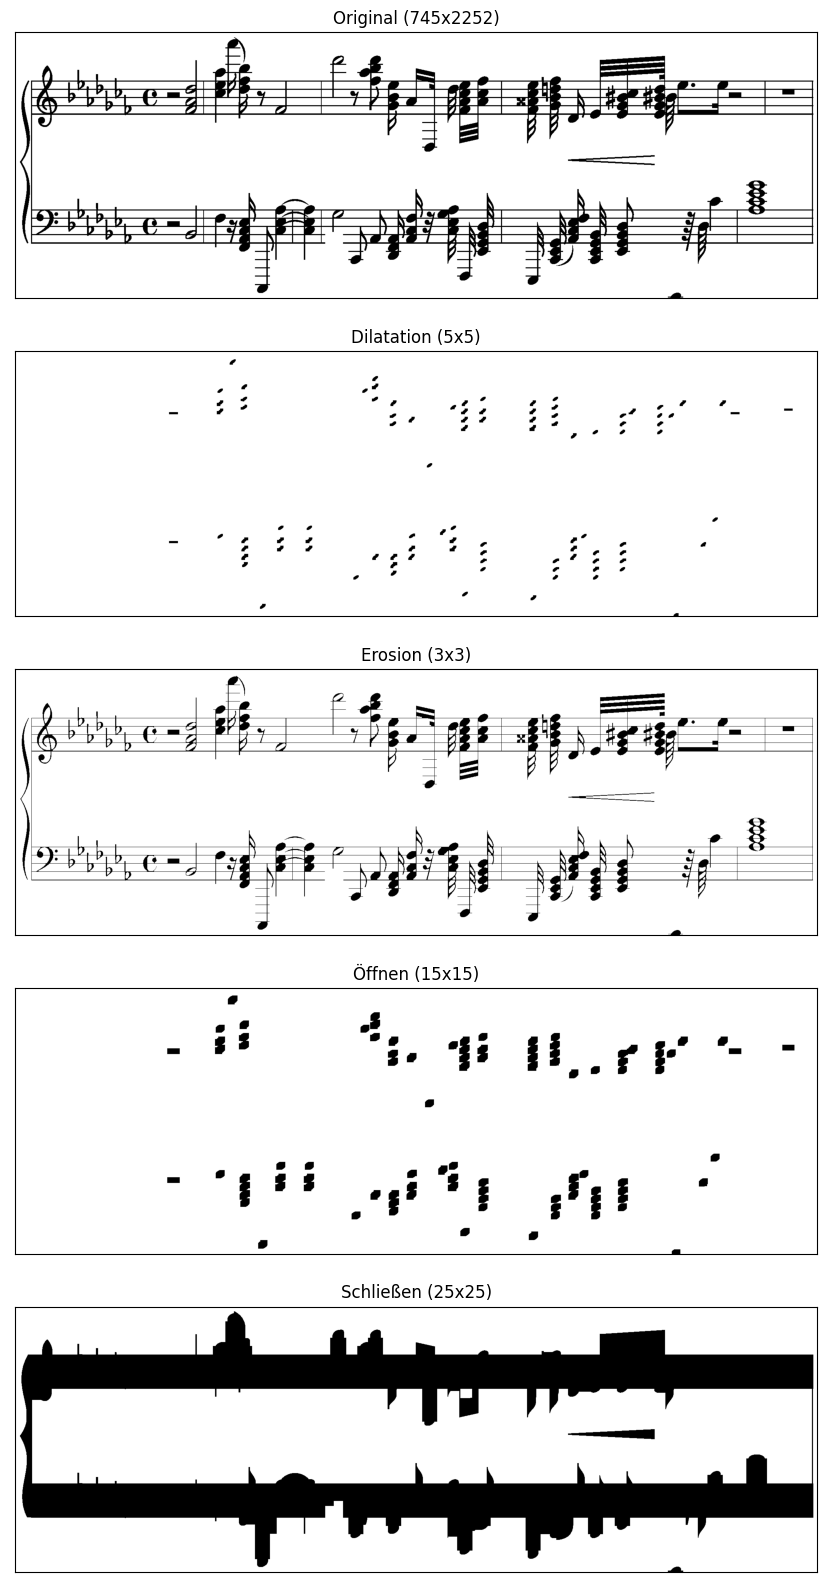

In [70]:
idx = 2
sample_idx = f"{idx:03d}"

orig_img_x = cv2.imread(os.path.join(PNG_PATH, f"{sample_idx}", "out-0.png"))
bboxes = load_bboxes(BBOX_PATH, sample_idx, img_shape=orig_img_x.shape)
# systems = [bbox for bbox in bboxes if bbox["type"]=="ClefG"]
systems = {bbox["id"]: bbox for bbox in bboxes if bbox["type"]=="System"}
print(len(systems))

# grab system
sys_idx = 0
eps = 15
system = systems[sys_idx]
x0 = system["x"] - eps
x1 = x0 + system["width"] + eps + eps
y0 = system["y"] - eps
y1 = y0 + system["height"] + eps + eps
sample = 255 - orig_img_x[y0:y1, x0:x1]

sample[560:, 870:920] = 0

# apply morph ops
results = [sample]
titles = [f"Original ({sample.shape[0]}x{sample.shape[1]})"]

# dilation
kernel_size = (15, 15)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.erode(sample, kernel)
kernel_size = (5, 5)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.dilate(res, kernel)
results.append(res)
titles.append(f"Dilatation ({kernel_size[0]}x{kernel_size[1]})")

# erosion
kernel_size = (3, 3)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.erode(sample, kernel)
results.append(res)
titles.append(f"Erosion ({kernel_size[0]}x{kernel_size[1]})")

# opening
kernel_size = (15, 15)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.morphologyEx(sample, cv2.MORPH_OPEN, kernel)
results.append(res)
titles.append(f"Öffnen ({kernel_size[0]}x{kernel_size[1]})")

# closing
kernel_size = (25, 25)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.morphologyEx(sample, cv2.MORPH_CLOSE, kernel)
results.append(res)
titles.append(f"Schließen ({kernel_size[0]}x{kernel_size[1]})")

# fig, axs = plt.subplots(1, len(results), figsize=(20, 20))
fig, axs = plt.subplots(len(results), 1, figsize=(20, 20))
for idx, res in enumerate(results):
    vis = res
    vis = 255 - vis
    axs[idx].imshow(vis)
    axs[idx].get_xaxis().set_visible(False)
    axs[idx].get_yaxis().set_visible(False)
    axs[idx].set_title(titles[idx])
    cv2.imwrite(os.path.join("plots", f"{titles[idx]}.png"), vis)
os.path.join(PNG_PATH, f"{sample_idx}", "out-0.png")